In [335]:
#Import Libaries - Data 
import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

import pandas as pd
import pandas_datareader as reader

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [310]:
#List of Companies to be analyzed
companies = ['AAPL','MSFT', 'AMD', 'INTC']
#Target company index
target = 0
#Sets the number of days the LSTM will use in the prediction
sample_size = 60

In [311]:
#Get previous stock quotes for predictor companies
quotes = reader.DataReader(companies, data_source='yahoo', start='2020-01-01')
quotes['Close']

Symbols,AAPL,MSFT,AMD,INTC
Date,,,,
2020-01-02,75.087502,160.619995,49.099998,60.840000
2020-01-03,74.357498,158.619995,48.599998,60.099998
2020-01-06,74.949997,159.029999,48.389999,59.930000
2020-01-07,74.597504,157.580002,48.250000,58.930000
2020-01-08,75.797501,160.089996,47.830002,58.970001
...,...,...,...,...
2020-10-22,115.750000,214.889999,79.419998,53.900002
2020-10-23,115.040001,216.229996,81.959999,48.200001
2020-10-26,115.050003,210.080002,82.230003,46.720001


<function matplotlib.pyplot.show>

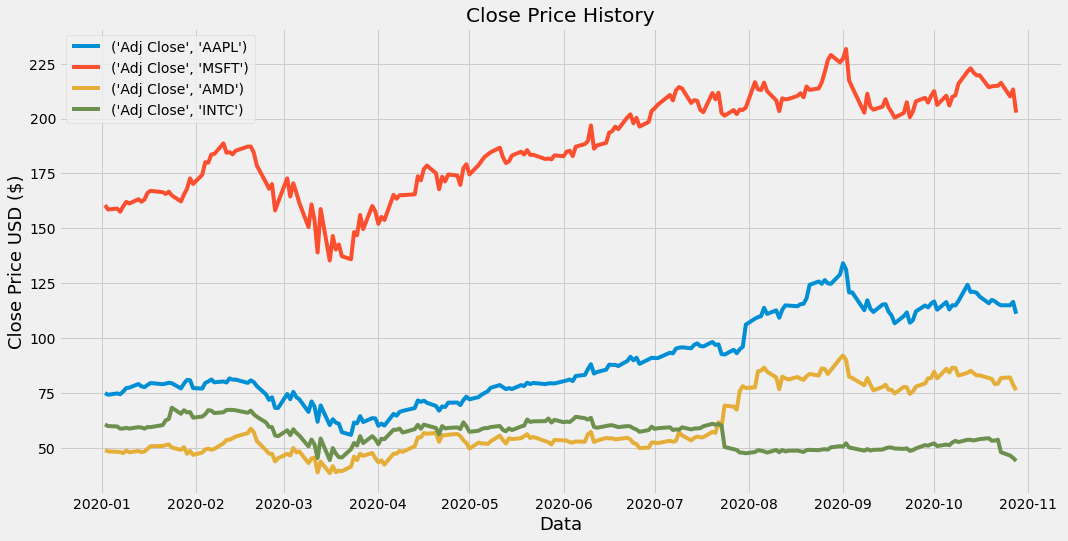

In [312]:
#Visualize the closing price history for company data
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(quotes.Close)
plt.legend(quotes)
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show

In [313]:
#Create new data frames from only the Close column
data = quotes.Close

#Convert the data frames to an array
dataset = data.values

#Convert the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

168

In [314]:
data

Symbols,AAPL,MSFT,AMD,INTC
Date,,,,
2020-01-02,75.087502,160.619995,49.099998,60.840000
2020-01-03,74.357498,158.619995,48.599998,60.099998
2020-01-06,74.949997,159.029999,48.389999,59.930000
2020-01-07,74.597504,157.580002,48.250000,58.930000
2020-01-08,75.797501,160.089996,47.830002,58.970001
...,...,...,...,...
2020-10-22,115.750000,214.889999,79.419998,53.900002
2020-10-23,115.040001,216.229996,81.959999,48.200001
2020-10-26,115.050003,210.080002,82.230003,46.720001


In [315]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset);
#scaled_data

In [316]:
scaled_data.shape

(209, 4)

In [317]:
len(scaled_data)

209

In [318]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

In [319]:
train_data

array([[0.24325282, 0.26187258, 0.19431455, 0.68497107],
       [0.23390428, 0.24108904, 0.18496352, 0.65441774],
       [0.24149191, 0.2453497 , 0.1810361 , 0.64739882],
       [0.23697783, 0.23028167, 0.17841782, 0.60611063],
       [0.25234517, 0.25636495, 0.17056298, 0.6077622 ],
       [0.27296307, 0.27714849, 0.19188333, 0.62138722],
       [0.27520409, 0.26935466, 0.17692162, 0.60652345],
       [0.2964303 , 0.28951472, 0.18776886, 0.63336083],
       [0.28272772, 0.27756425, 0.17766972, 0.62675473],
       [0.27843768, 0.28847548, 0.18402843, 0.60652345],
       [0.29092365, 0.31954693, 0.20684498, 0.63625099],
       [0.30209708, 0.32921136, 0.22853939, 0.63377365],
       [0.29518175, 0.32297624, 0.23078361, 0.67299746],
       [0.2987995 , 0.31466279, 0.23789042, 0.76300572],
       [0.30369785, 0.32526244, 0.24312698, 0.78736576],
       [0.30075239, 0.30780418, 0.21769215, 1.        ],
       [0.27078605, 0.27912295, 0.19730688, 0.88521888],
       [0.29876746, 0.31216886,

In [320]:
#Change the train data into a numpy array
train_data = np.array(train_data)
#Transpose the train data array
train_data = train_data.T
train_data[0]

array([0.24325282, 0.23390428, 0.24149191, 0.23697783, 0.25234517,
       0.27296307, 0.27520409, 0.2964303 , 0.28272772, 0.27843768,
       0.29092365, 0.30209708, 0.29518175, 0.2987995 , 0.30369785,
       0.30075239, 0.27078605, 0.29876746, 0.32005766, 0.31855293,
       0.27257891, 0.26985758, 0.30248125, 0.31080527, 0.32284298,
       0.30625904, 0.31112534, 0.30491435, 0.3292141 , 0.32175447,
       0.32201064, 0.30296146, 0.31775255, 0.30712342, 0.28391228,
       0.23630544, 0.20396989, 0.21860094, 0.15735552, 0.15684327,
       0.23832242, 0.20793987, 0.25090444, 0.21946542, 0.20701139,
       0.1338243 , 0.19519771, 0.16347047, 0.07638867, 0.1716024 ,
       0.05711546, 0.09121181, 0.07139428, 0.06534338, 0.01559152,
       0.        , 0.07206663, 0.06771254, 0.10907639, 0.07481995,
       0.09745479, 0.09578998, 0.05295345, 0.06582359, 0.05455422,
       0.12197858, 0.11224588, 0.13350413, 0.13965103, 0.15649114,
       0.20067231, 0.1922843 , 0.19951981, 0.18706578, 0.16827

In [321]:
#Create a numpy array of x train data 
#LSTM expects the input to be 3 dimensional in the form num of samples, num of timesteps, num of features
x_train = 0
x_train_flag = 0
for comp in range(train_data.shape[0]):
  x_train_layer = []
  for i in range(sample_size, train_data.shape[1]):
    x_train_layer.append(train_data[comp][i - 60: i]);
  x_train_layer = np.array(x_train_layer)
  if (x_train_flag == 0):
    x_train = x_train_layer
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_train_flag = 1
  else:
    x_train_layer = np.reshape(x_train_layer, (x_train_layer.shape[0], x_train_layer.shape[1], 1))
    x_train = np.concatenate((x_train, x_train_layer), axis=2)
  
x_train.shape

(108, 60, 4)

In [322]:
#Create a list of y training values
y_train = []
for i in range(60, train_data.shape[1]):
  y_train.append(train_data[target][i])
print(len(y_train))

108


In [323]:
#Convert y_train into a numpy array
y_train = np.array(y_train)

In [336]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [338]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [340]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

ValueError: ignored